#  Introduction
************************************************************************************

In the era of ‘big data’, vast amounts of data are being collected and curated in the form of
arrays across the social, physical, engineering, biological, and ecological sciences.  Analysis of
the data relies on a variety of matrix decomposition methods which seek to exploit low-rank
features exhibited by the high-dimensional data.  Indeed, matrix decompositions are often the
workhorse algorithms for scientific computing applications in the areas of applied mathematics,
statistical  computing,  and  machine  learning.   Despite  our  ever-increasing  computational
power, the emergence of large-scale datasets has severely challenged our ability to analyze
data  using  traditional  matrix  algorithms.   Moreover,  the  growth  of  data  collection  is  far
outstripping computational performance gains.  The computationally expensive singular value
decomposition  (SVD)  is  the  most  ubiquitous  method  for  dimensionality  reduction,  data
processing and compression.  The concept of randomness has recently been demonstrated as
an effective strategy to easing the computational demands of low-rank approximations from
matrix decompositions such as the SVD, thus allowing for a scalable architecture for modern
‘big data’ applications.  Randomness as a computational strategy is interesting if we an make the following assumption:  the data matrix to be approximated has low-rank structure, i.e., the rank is smaller than the ambient
dimension of the measurement space. Fortunately, this assumption is valid for most machine learning applications.

##  Brief Review of the Singular Value Decomposition (SVD)
************************************************************************************
The SVD provides a numerically stable matrix decomposition that can be used to obtain
low-rank approximations, to compute the pseudo-inverses of non-square matrices, and to find
the least-squares and minimum norm solutions of a linear model.  Further, the SVD is the
workhorse algorithm behind many machine learning concepts, for instance, matrix completion,
sparse coding,  dictionary learning,  PCA and robust PCA. 

Suppose we are given a $m\times n$ matrix $\mathbf{A}$, where $m$ denotes the number of rows and $n$ the number of columns. Without loss of generality we assume that $n\leq m$. The singular value decomposition admits the following factorization 

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{A}  & \approx & \mathbf{U} & \mathbf{\Sigma}  & \mathbf{V}^\top\\
	m\times n &   &  m\times n & n\times n  & n\times n
	\end{array} 
\end{equation}

$\mathbf{U}$ denotes the left singular vectors, $\mathbf{V}$ are the right singular, and $\mathbf{\Sigma}$ contains the non-negative singular values vectors. In many applications the numeric rank $r$ of a matrix is much smaller than the ambient dimensions of the input matrix 


<img src="img/svd.png" alt="Drawing" style="width: 600px;"/>

This is, for instance, the case if some of the information in the data are redundant.
In such situations we are interested in computing as few components as possible. This leads to the concept of low-rank factorizations, where we try to represent the original data matrix by using as few singular vectors as possible. Often, we define a desired target-rank $k$ to yield the following factorization

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{A}  & \approx & \mathbf{U} & \mathbf{\Sigma}  & \mathbf{V}^\top\\
	m\times n &   &  m\times k & k\times k  & k\times n
	\end{array} 
\end{equation}

Choosing  an  optimal  target  rank $k$ is  highly  dependent  on  the  task.   One  can  either  be interested in a highly accurate reconstruction of the original data, or in a very low dimensional representation of dominant features in the data.  In the former case $k$ should be chosen close to the effective rank, while in the latter case $k$ might be chosen to be much smaller.

##  Randomized Singular Value Decomposition (RSVD)
************************************************************************************
Randomized algorithms have been recently popularized, in large part due to their ‘surprising’
reliability and computational efficiency to obtain an approximate rank-$k
$ factorization. When the dimensions of $\mathbf{A}$ are large, randomized methods are more efficient than truncating the full SVD. We omit technical details here, but refer the interesting reader to this neat blog post by Andrew Tulloch (Facebook Reserach):

* https://research.fb.com/fast-randomized-svd/

For a more technical treatmeant we refer to the papers:

* Randomized algorithms for matrices and data (https://arxiv.org/abs/1104.5557)
* Finding structure with randomness (https://arxiv.org/abs/0909.4061)
* Randomized Matrix Decompositions using R (https://arxiv.org/pdf/1608.02148.pdf)


To demonstrate the randomized SVD we use image compression and image denoising as an example in the following. 

### The Ristretto Package
You can find randomized methods for linear algebra in scikit learn to compute the SVD and PCA. Here, we use the ristretto package, which provides a collection of randomized algorithms for a broard range of applications. This package is still under developmeant, and you will see many more features to come. Just have a look:

* https://ristretto.readthedocs.io/en/latest/
* https://github.com/erichson/ristretto

You don't have to worry about it for this tutorial, but installation is easy:

``` pip install ristretto```

Feedbeck is warmly welcome! We can build and provide better tools if we know your needs. Just drop me an email ( erichson@berkeley.edu ) with any suggestions or comments or use git ( https://github.com/erichson/ristretto/projects ). 

# Let's Get Started

Here are the libraries we are going to use in this tutorial:

In [3]:
import numpy as np
import scipy as sci
from scipy import ndimage 
from tqdm import trange
import h5py
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white")
from misc import *

Next, we read-in a image which we will use in the following for demonstration:

In [ ]:
# Read in image
A = plt.imread('./data/lion.jpg')

# Convert to a grayscale image
A = np.dot(A[...,:3], [0.299, 0.587, 0.114])

# Display image
fig = plt.figure(figsize=(11, 9))
plt.imshow(A, cmap = 'gray')
plt.axis('off')
plt.show()

## Computing the truncated SVD using Numpy

We start by defining a new function ```tsvd()``` to compute the truncated SVD so that we can pass the desired target-rank as an arguement. The function returns the truncated singular vectors and values. 

In [ ]:
from numpy.linalg import svd
def tsvd(A, rank):
    U, s, Vt = np.linalg.svd(A , full_matrices=False)
    return U[:,0:rank], s[0:rank], Vt[0:rank,:]

Now, we compute the truncated SVD to compress the above image. For instance, we can decide to use the target-rank 200:

In [ ]:
%%time
U, S, Vt = tsvd(A, rank=200)

We can reconstruct the original image as:

In [ ]:
A_appox = (U*S).dot(Vt)

The relative error is:

In [ ]:
print('Relative reconstruction error:', np.linalg.norm(A-A_appox) / np.linalg.norm(A))

Can we get a nearly as good result, but faster? Let's try the randomized SVD.

In [ ]:
from ristretto.svd import compute_rsvd as rsvd

In [ ]:
%%time
U, S, Vt = rsvd(A, rank=200, oversample=20, n_subspace=2)

That was fast, but how good did we do?

In [ ]:
A_rand_appox = (U*S).dot(Vt)
print('Relative reconstruction error:', np.linalg.norm(A-A_rand_appox) / np.linalg.norm(A))

Not good enough? Well, go back and try to change the oversample parameter value to 50.

Now, let's do a visual comparision:

In [ ]:
# Display image
f = plt.figure(figsize=(22,9))
f.add_subplot(121)
plt.imshow(A_appox, cmap = 'gray')
plt.axis('off')
plt.title('Deterministic SVD', fontsize=22)

f.add_subplot(122)
plt.imshow(A_rand_appox, cmap = 'gray')
plt.axis('off')
plt.title('Randomized SVD', fontsize=22)
plt.show()

# Robust PCA

In many data science applications we need robust methods which can more effectively account for corrupt or missing data.  Indeed, outlier rejection is critical in many applications as data is rarely free of corrupt elements.
Robustification methods decompose data matrices as follows:

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{A}  & \approx & \mathbf{L} & \mathbf{E}\\
	m\times n &   &  m\times n & m\times n 
	\end{array} 
\end{equation}
where $\mathbf{L}$ denotes a low-rank matrix and $\mathbf{E}$ a sparse matrix capturing the corrupted entries (outliers) of the input data matrix.

This  form of additive decomposition (i.e., the  decomposition  of  a  matrix  into  its  sparse  and  low-rank  components) is also denoted as robust principal component analysis (RPCA). Its remarkable ability to separate high-dimensional matrices into low-rank and sparse component makes RPCA an invaluable tool for data science. However, the biggest challenge for robust PCA is computational efficiency, especially given the iterative
nature of the optimization required.

## Corrupted Data

Let's add some salt and pepper noise to our image:

In [ ]:
Anoisy = noisy("s&p", A, amount=0.05)

In [ ]:
# Display image
fig = plt.figure(figsize=(11, 9))
plt.imshow(Anoisy, cmap = 'gray')
plt.axis('off')
plt.show()

Now, computing just the SVD provides no good approximation:

In [ ]:
U, S, Vt = rsvd(Anoisy, rank=200)
print(np.linalg.norm(A-(U*S).dot(Vt)) / np.linalg.norm(A) )

In [ ]:
# Display image
fig = plt.figure(figsize=(11, 9))
plt.imshow((U*S).dot(Vt), cmap = 'gray')
plt.axis('off')
plt.show()

Instead we can use a robust decompositions. Computing the robust PCA is based on an iterative scheme, requiring to computing the SVD in each iteration. The computational costs can be drastic using the deterministic SVD. In the following we have compiled some toy code to compute the robust PCA. Note, this is code is not intended to be used in practice (there are better algorithms), but it is simple and demonstrates the idea. 

In [ ]:
def robust_pca(A, rank, alpha, max_iter):
    
    # Init
    E = np.zeros_like(A) 
    alpha *= np.linalg.norm(A, 2)**2 
    
    for i in trange(max_iter):
        
        # i) Compute the SVD
        U, s, Vt = tsvd(A-E, rank=rank)
        
        # ii) Compute prox gradient step
        grad = E - (A - (U*s).dot(Vt))
        E = E - 0.1 * grad
        
        # iii) Soft threshold (l1 regularization)
        E = np.clip(abs(E) - alpha * 0.1, 0, None) * np.sign(E)    
        
        
    return (U*s).dot(Vt), E

Okay, let's run the algorithm using the truncated SVD for a maximum of 20 iterations:

In [ ]:
Are, E = robust_pca(Anoisy, rank=200, alpha=1e-9, max_iter=20)
print('Relative reconstruction error:', np.linalg.norm(A-Are) / np.linalg.norm(A))

This takes quite some time!!! Can you change the code and use the ```rsvd()``` function instead? Rerun the code.

Now, this should be a bit faster, right? So we can increase the number of max iteration, say, to 50. This should improve the reconstruction error quite a bit.

Let's plot the results:

In [ ]:
# Display image
f = plt.figure(figsize=(22,9))
f.add_subplot(121)
plt.imshow(Are, cmap = 'gray')
plt.axis('off')
plt.title('Reconstructed Image', fontsize=22)

f.add_subplot(122)
plt.imshow(E, cmap = 'gray')
plt.axis('off')
plt.title('Removed Outliers', fontsize=22)
plt.show()


# Scaling the SVD

Now, we use the SVD to extract features from high-resolution sea surface temperature (SST) data.  The SST data are widely studied in climate science for climate monitoring and prediction, providing an improved understanding
of the interactions between the ocean and the atmosphere. Specifically, the daily SST measurements are constructed by combining infrared satellite data with observations provided by ships and buoys.  In order to account and compensate for platform differences and sensor errors, a bias-adjusted methodology is used to combine the measurements from the different sources.  Finally, the spatially complete SST map is produced via interpolation. The data are provided by the National Oceanic and Atmospheric Administration (NOAA) via their web site at https://www.esrl.noaa.gov/psd/.  

Data are available for the years from 1981 to 2018 with a temporal resolution of 1 day and a spatial grid resolution of $0.25$ grad.  In total, the data consists of $m = 13,149$ temporal snapshots which measure the daily temperature
at $1440×720 = 1,036,800$ spatial grid points.  Since we omit data over land, the ambient dimension reduces to
$n= 691,150$ spatial measurements in our analysis. Concatenating the reduced data yield a 36GB data matrix of dimension $691,150×13,149$, which is sufficiently large to test scaling.

The data are stored in a hdf5 file and are to big to fit into our fast memory. However, the hdf5 data format allows us to efficentlys access parts of the data, i.e., we can read in some columns or some rows. We start by creating a new h5py object:

In [ ]:
f = h5py.File("./data/sstHD.hdf5", "r")

Now, we can visualize a couple of th snapshots:

In [ ]:
plot_frames(f['sstHD'][:,[0,1000,2000,3000,4000,5000]], x=2, y=3)

Trying to use the SVD provided by Numpy or Scipy will result into a memory error (you can try it yourself):

In [ ]:
#U, s, Vt = tsvd(f['sstHD'], rank=10)

The randomized SVD function provided by the ristretto package allows us to compute the SVD using a blocked scheme. You can controll the number of blocks via the argument ```n_blocks```:

In [ ]:
%%time
U, s, Vt = rsvd(f['sstHD'], rank=10, n_blocks=5)

In [ ]:
Now, we can plot the extraxted modes (left singular vectors). 

In [ ]:
plot_frames(U, x=2, y=3)

The lower middle plot identifies the intermittent El Niño and La Niña warming events, which are famously implicated in global weather patterns and climate change. The El Niño Southern Oscillation (ENSO) is defined as any sustained temperature anomaly above running mean temperature with a duration of 9 to 24 months. The canonical El Niño is associated with a narrow band of warm water off coastal Peru that is commonly referred as NIÑO 1+2, 3, 3.4, or 4 to differentiate the types of bands. This mode is often used to compute the canonical Oceanic Niño Index (ONI).

# Some more Insights about the Randomized SVD

The ristretto package advocates a two-stage probabilistic framework to compute a near-optimal low-rank approximation.  Conceptually, this framework splits the computation into the two logical steps:

* $\textbf{Stage A:}$ Construct a low dimensional subspace that approximates the range of $\mathbf{A} \in \mathbb{R}^{m\times n}$. Specifically, it is the aim to find a matrix $\mathbf{Q} \in \mathbb{R}^{m\times k}$ with orthonormal columns, where $k$ denotes the target rank, such that $\mathbf{A} \approx \mathbf{Q}\mathbf{Q}^\intercal\mathbf{A}$ is satisfied. 

* $\textbf{Stage B:}$ Form a smaller matrix $\mathbf{B} \in \mathbb{R}^{k\times n}$ by restricting the high-dimensional input matrix to the low-dimensional space spanned by the near-optimal basis $\mathbf{Q}$. This smaller matrix can then be used to compute a desired low-rank approximation.

The first computational stage is where randomness comes into the play, while the second stage
is purely deterministic.  In the following, the two stages are described in more detail. Pictorially, here is what we do:


<img src="img/stageA.png" alt="Drawing" style="width: 600px;"/>



### Stage A
***********

Okay, now the first step is to generate a random test matrix $\mathbf{\Omega}$ of dimension $n \times l$ were $l=k+p$. Here, we need to define a target rank $k$, i.e, we need to decide how many dominant singular vectors and values we aim to approximate. Further, to improve the approximation accuracy, we introduce some slight oversampling in addition, here we use $p=20$. We will use the image, which we used at the very beginning, as an example again.

In [5]:
A = plt.imread('./data/lion.jpg') # Read image
A = np.dot(A[...,:3], [0.299, 0.587, 0.114]) # Convert to a grayscale image
m, n = A.shape # Get shape

We start with drawing the entries of $\mathbf{\Omega}$ from the standard normal distribution:

In [6]:
k, p = 200, 20

In [7]:
Omega = sci.random.standard_normal((n, (k+p))) # standard normal distribution

Next, we compute the samples matrix $\mathbf{Y}$, i.e., we sketch the column space of the input matrix (image) $\mathbf{A}$.

In [8]:
Y = A.dot(Omega)

To improve the accuracy of the basis, we can perform additional power iterations. We leave this as an exercise, but skip this for the moment. If you need some guidance, have a look to https://arxiv.org/pdf/1608.02148.pdf on page 9 to Algorithm 2. 

In [10]:
q = 2 # number of (optional) power iterations

#for i in range(q):
    # compute QR decomposition of Y
    # compute QR decomposition of A.T.dot(Q) 
    # update samples matrix Y as Y = A.dot(Q)

$\mathbf{Y}$ forms a basis for the column space of the input matrix, we can use the 'economic' QR decomposition to form a orthonormal basis, so that $\mathbf{Q}^\top\mathbf{Q}=\mathbf{I}$. 

In [11]:
Q , _ = sci.linalg.qr(Y ,  mode='economic' ) 

### Stage B
************
Now, having $\mathbf{Q}$, we aim to find a smaller matrix $\mathbf{B} \in \mathbb{R}^{l \times n}$. Therefor, we simply project the high-dimensional input matrix $\mathbf{A}$ to the low-dimensional space as 
\begin{equation}
\mathbf{B} = \mathbf{Q}^\top\mathbf{A}.
\end{equation}


In [12]:
B = Q.T.dot(A)

The approximate SVD is computed using a standard (deterministic) algorithm so that we attain the following decomposition
\begin{equation} 
\mathbf{B} = \mathbf{\tilde{U}} \mathbf{\Sigma}\mathbf{V}^\top.	
\end{equation} 


In [14]:
Utilde, s , Vt = np.linalg.svd( B , full_matrices=False)

It remains to recover the high-dimensional left singular vectors. Recall that
	$\mathbf{A} \approx  \mathbf{Q}{\mathbf{Q^{\top}}\mathbf{A}} = \mathbf{Q} {\mathbf{B}} = \mathbf{Q}\mathbf{\tilde{U}} \mathbf{\Sigma}\mathbf{V^{\top}}= \mathbf{U} \mathbf{\Sigma}\mathbf{V^{\top}}$. Hence, $\mathbf{\tilde{U}}:= \mathbf{Q}\mathbf{\tilde{U}}$.	

In [15]:
U = Q.dot(Utilde)

Let's see how good the approximation is.

In [17]:
A_rsvd = (U*s).dot(Vt)

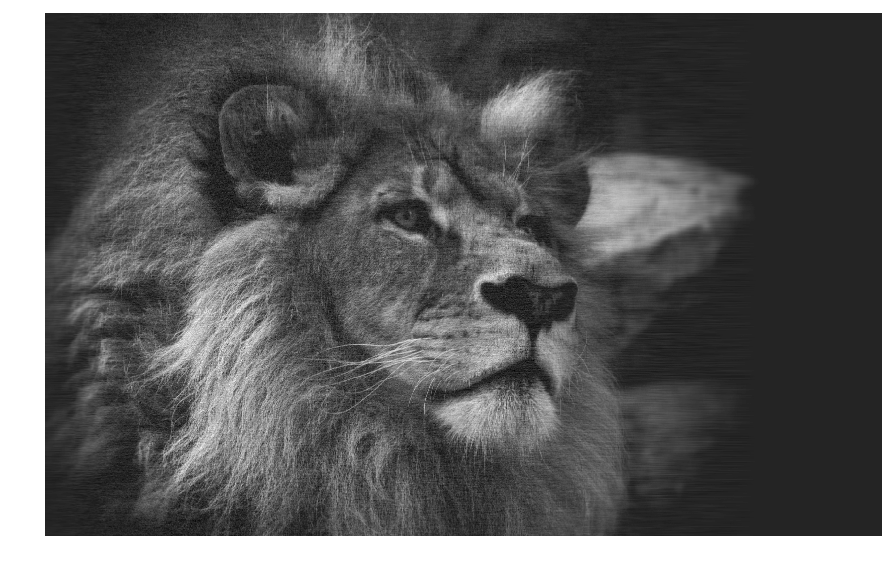

In [18]:
# Display image
fig = plt.figure(figsize=(15, 11))
plt.imshow(A_rsvd, cmap = 'gray')
plt.axis('off')
plt.show()

We can compute the relative reconstruction error to quantify the performance of the randomized algorithm.

In [19]:
#Print relative error
print('Relative error:', sci.linalg.norm(A-A_rsvd)/sci.linalg.norm(A))

Relative error: 0.165234039919


Now, try it with two additional power iterations / subspace iterations and see if you can improve the error.